In [1]:
# Import standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import for text analytics
import spacy
from spacy import displacy
import string
from collections import Counter
import re


# Import for text analytics
import spacy
from spacy import displacy
import string

# Load English language model of spacy
sp = spacy.load('en_core_web_sm')

# Introduction to the Notebook

The primary purpose of this notebook is:

- Data exploration 
- Understanding opportunities and limitations
- Creating research foundation for model

The notebook is built as the following:
- Dataset import and discovery
- Exploratory Data Analyses (EDA)
    - Explore word/sentence correlation
    - Look at company affiliation 
    - Understand time period of given data

# Prelimanary Analysis

### Data explanation 
The dataset from the ETH Zürich research department is publicly available on [huggingface](https://huggingface.co/datasets/climatebert/environmental_claims/tree/main) to stimulate continuous research and collaboration to advance on sustainability actions globally. The dataset contains 3000 human-annotated environmental claims. Within the dataset, 16 domain experts labelled a claim to be environmentally based on the definition of an environmental claim, which is the following: An environmental claim “refers to the practice of suggesting or otherwise creating the impression (in the context of a commercial communication, marketing or advertising) that a product or a service is environmentally friendly (i.e., it has a positive impact on the environment) or is less damaging to the environment than competing goods or services.” Important to note is that the dataset solely focuses on claims of a length between 10 to 40 words. In addition, all the claims in the dataset have been made in sustainability reports, earning calls, and annual reports. Lastly, it is important to keep in mind that the dataset, might be biased, since it was mainly built based on financial claim statements. Therefore, when exploring Greenwashing in another sector, the accuracy of the model can not be guaranteed.


### Import data set

In [2]:
# Import training dataset
url_train = "https://github.com/Clahrens/corporate_greenwashing/raw/main/data_environmental_claims/train.jsonl"
df_train = pd.read_json(url_train, lines=True)

# Import testing dataset
url_test = "https://github.com/Clahrens/corporate_greenwashing/raw/main/data_environmental_claims/test.jsonl"
df_test = pd.read_json(url_test, lines=True)

### Dataset Discovery

In [3]:
import spacy
import unidecode
sp = spacy.load("en_core_web_sm")

Information on the training dataset:
---------------------------------------------

There are 2400 observations in the training dataset.


 - There are 1858 observations that are not related to the environment (label = 0)
 - There are 542 observations that are environmental claims (label = 1).
 - The ratio of environmental claims is 22.58%.


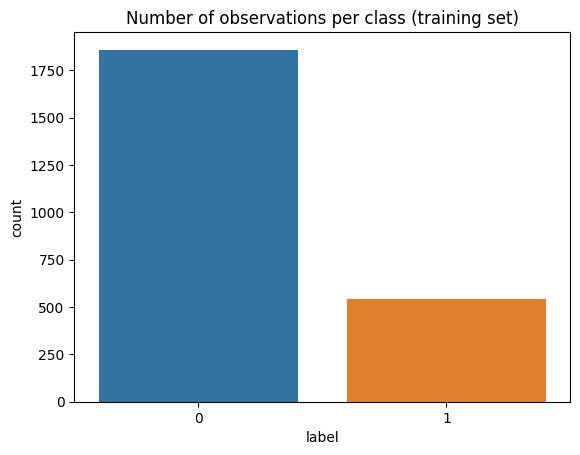

Example of Environmental Claim:
The goal to reduce relative GHG emissions by 20% by 2020 was achieved in 2013.

Example of Non-Environmental Claim:
As part of this program we are expecting to increase the seat density on our Airbus A320 fleet.


In [4]:
# Information on the training dataset
print("Information on the training dataset:")
print(f"{'-' * 45}")
print('')

# display the number of observations
num_observations = len(df_train)
print(f"There are {num_observations} observations in the training dataset.")
print('')
print('')

# display the number of observations per class
num_0 = (df_train['label'] == 0).sum()
num_1 = (df_train['label'] == 1).sum()
ratio = (num_1/num_observations)*100
print(f" - There are {num_0} observations that are not related to the environment (label = 0)")
print(f" - There are {num_1} observations that are environmental claims (label = 1).")
print(f" - The ratio of environmental claims is {ratio:.2f}%.")

#plot 
column_name = 'label'
value_counts = df_train[column_name].value_counts()
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title(f'Number of observations per class (training set)')
plt.xlabel(column_name)
plt.ylabel('count')
plt.xticks([0, 1])
plt.show()

# Diclose exemples of claims  
label_1_indexes = df_train[df_train['label'] == 1].index
label_1_observation = df_train.loc[label_1_indexes[0], 'text']
print(f"Example of Environmental Claim:\n{label_1_observation}")
print('')
label_0_indexes = df_train[df_train['label'] == 0].index
label_0_observation = df_train.loc[label_0_indexes[123], 'text']
print(f"Example of Non-Environmental Claim:\n{label_0_observation}")

Information on the testing dataset:
---------------------------------------------

There are 300 observations in the testing dataset.


- There are 236 observations that are not related to the environment (label = 0)
- There are 64 observations that are environmental claims (label = 1).
- The ratio of environmental claims is 21.33%.


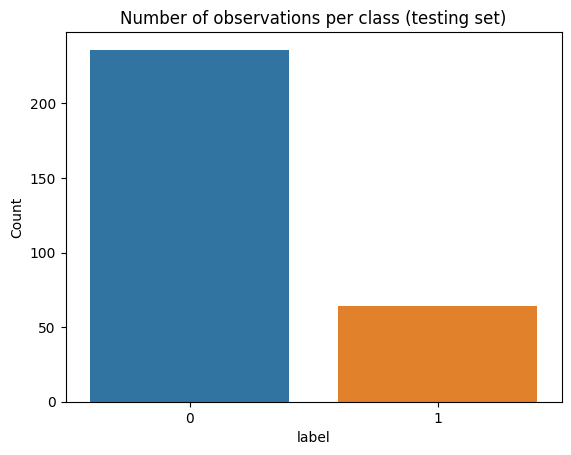

Exemple of Environmental Claim:
1,3-BAC easy to use, and its fast curing speed reduces the environmental impact of the production process.

Example of Non Environmental Claim:
So cohorts like young moms and young dads and broader audiences, that's been very important.


In [5]:
# Information on the testing dataset
print("Information on the testing dataset:")
print(f"{'-' * 45}")
print('')

# display the number of observations
num_observations = len(df_test)
print(f"There are {num_observations} observations in the testing dataset.")
print('')
print('')

# display the number of observations per class
num_0 = (df_test['label'] == 0).sum()
num_1 = (df_test['label'] == 1).sum()
ratio = (num_1/num_observations)*100
print(f"- There are {num_0} observations that are not related to the environment (label = 0)")
print(f"- There are {num_1} observations that are environmental claims (label = 1).")
print(f"- The ratio of environmental claims is {ratio:.2f}%.")

#plot 
column_name = 'label'
value_counts = df_test[column_name].value_counts()
sns.barplot(x=value_counts.index,y=value_counts.values)
plt.title(f'Number of observations per class (testing set)')
plt.xlabel(column_name)
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()

# Diclose exemples of claims  
label_1_indexes = df_test[df_test['label'] == 1].index
label_1_observation = df_test.loc[label_1_indexes[1], 'text']
print(f"Exemple of Environmental Claim:\n{label_1_observation}")
print('')
label_0_indexes = df_test[df_test['label'] == 0].index
label_0_observation = df_test.loc[label_0_indexes[123], 'text']
print(f"Example of Non Environmental Claim:\n{label_0_observation}")


After evaluating the information provided, it can be determined that our **default rate is 78.67%** (100% - 21.33%). This percentage holds significance as it will serve as the benchmark for comparing our predictive model in subsequent analysis.

Furthermore, based on the initial analysis conducted earlier, we have identified two instances of sentences classified as environmental claims. In the subsequent section of the exploratory data analysis (EDA), we will delve deeper into the specific words that form these sentences.

# Exploratory Data Analysis (EDA)

For the following analyses, we take a closer look at the training set of non-/ environmental claims.

#### 1. Explore words within sentences
First, we take apart individual sentences to look at single words of the sentence. The goal is to explore and understand the constitution of sentences within out dataset. 

In [6]:
# Receive more information on the words within the claim

# Total number of words per claim in the training set
observations = len(df_train)
words_number = df_train["text"].apply(lambda x: len(x)).sum()
words_min = df_train["text"].apply(lambda x: len(x.split())).min()
words_max = df_train["text"].apply(lambda x: len(x.split())).max()
print("In total there are:", words_number, "words within the training dataset containing", observations,"claims.")
print("The shortest sentence consists of:", words_min, "words.")
print("The longest sentence consists of:", words_max, "words.")

# Number of words per claim
df_train["word_count"] = df_train["text"].apply(lambda x: len(x.split()))
df_train["word_count"].describe()

In total there are: 364767 words within the training dataset containing 2400 claims.
The shortest sentence consists of: 11 words.
The longest sentence consists of: 39 words.


count    2400.00000
mean       24.44125
std         7.54516
min        11.00000
25%        18.00000
50%        24.00000
75%        30.00000
max        39.00000
Name: word_count, dtype: float64

Important to keep in mind is that the training data excludes really short sentences as well as very long sentences, which might biases the model we are going to train.
After having a numerical idea of words count, next up we will look at the content of these words.

,Frequency
Word,
the,2796
and,1975
to,1969
of,1770
in,1320
a,895
our,843
we,696
that,635


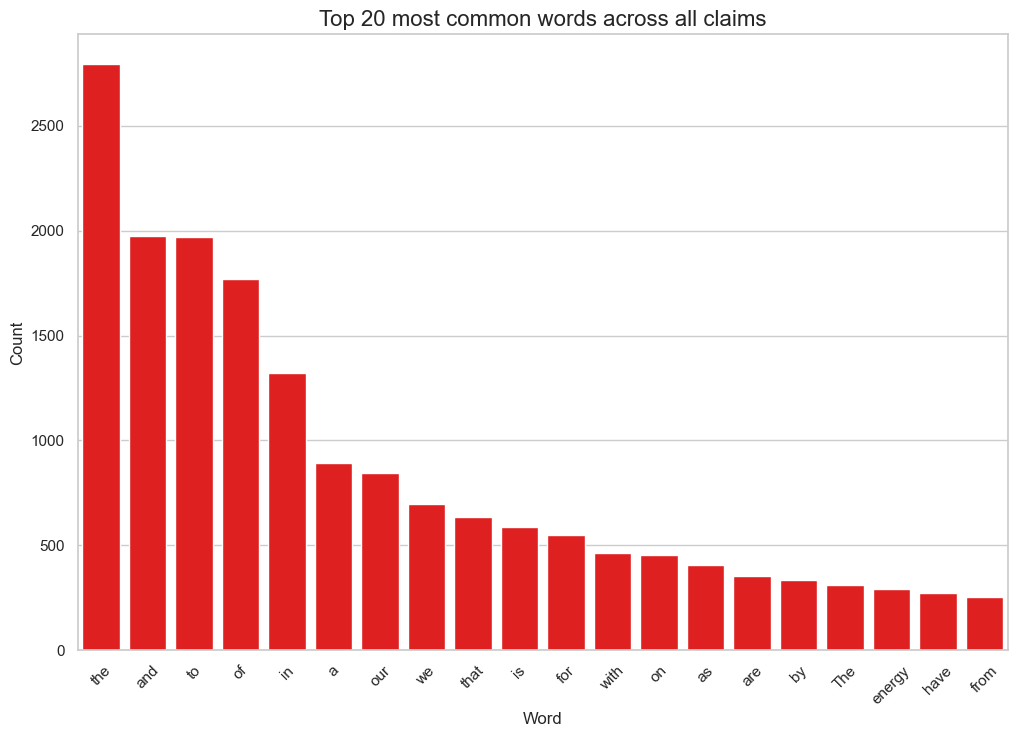

In [7]:
# Combine all claims' text into a single string
all_text = ' '.join(df_train['text'].tolist())

# Tokenize the text by splitting on whitespace
words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Get n most frequent words
n = 20  # Specify the number of most frequent words I want to retrieve
most_frequent_words = word_counts.most_common(n)

# create a list of most frequent words
most_common = [{"Word": word, "Frequency": frequency} for word, frequency in most_frequent_words]
word_common = pd.DataFrame(most_common)
word_common.set_index("Word",inplace=True)
display(word_common)

#visualize the 10 most common words in a bar chart 
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.barplot(x=word_common.index[:20], y=word_common["Frequency"][:20], color="red")
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 20 most common words across all claims", fontsize=16)
plt.xticks(rotation=45)

plt.show()

The provided bar charts indicate that the prevalent words in the dataset mainly consist of basic terms that do not contribute significant information regarding the central content of the phrases.

Given this observation, the objective is to eliminate these words using adding more constraints on our tokenizer. By doing so, we can eliminate words that have minimal impact on the sentence's meaning and gain a clearer understanding of the central content.

Now, we will specifically focus on environmental claims to conduct this analysis and identify the most frequently occurring words within them.

In [8]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation +'–' + '—'
    numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = ([ word.lemma_.lower().strip() for word in mytokens ])

    # Remove stop words and punctuation
    mytokens = ([ word for word in mytokens 
                 if word not in stop_words and word not in punctuations ])

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
        for char in word:
            if (char in punctuations) or (char in numbers):
                word = word.replace(char, "")
        if word != "":
            mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2

In [9]:
# Create a copy data frame
df_tokenized = df_train.copy()

# Apply the tokenizer function to the 'text' column
df_tokenized['tokens'] = df_tokenized['text'].apply(spacy_tokenizer)

# Print the DataFrame with tokenized text
df_tokenized

,text,label,word_count,tokens
0,It will enable E.ON to acquire and leverage a ...,0,34,"[enable, eon, acquire, leverage, comprehensive..."
1,And that's honestly most markets in the U.S. S...,0,37,"[honestly, market, us, fact, think, opportunit..."
2,A key pillar of our strategy is to continue to...,0,39,"[key, pillar, strategy, continue, adapt, busin..."
3,The goal to reduce relative GHG emissions by 2...,1,15,"[goal, reduce, relative, ghg, emission, achieve]"
4,"As you know, we drove about $75 million of cos...",0,17,"[know, drive, million, cost, synergy, year, fi..."
...,...,...,...,...
2395,The collaboration will enable Nestlé to delive...,1,26,"[collaboration, enable, nestlé, deliver, susta..."
2396,Through the MOBILITY THAT ADAPTS TO MEET NEEDS...,0,35,"[mobility, adapts, meet, need, renault, tech, ..."
2397,While we are making progress towards our near ...,0,25,"[progress, near, term, goal, case, exceed, tar..."
2398,"On 5 December 2019, the Federal Network Agency...",0,27,"[december, federal, network, agency, confirm, ..."


After creating the tokenized column, we want to select only environmental claims, meaning we will filter for labels = 1. 

In [10]:
# Replace commas with spaces and convert the lists to strings
df_tokenized['tokens'] = df_tokenized['tokens'].apply(lambda x: ' '.join(x))

# Filter observations with label equal to 1
df_train_bis = df_tokenized[df_tokenized['label'] == 1].copy()

# Reset the index of the new DataFrame
df_train_bis.reset_index(drop=True, inplace=True)

# Print the new DataFrame
df_train_bis

,text,label,word_count,tokens
0,The goal to reduce relative GHG emissions by 2...,1,15,goal reduce relative ghg emission achieve
1,1.2 Significant Changes to Assets In February ...,1,38,significant changes asset february agl create ...
2,This not only provides a clean energy solution...,1,23,provide clean energy solution improve basic sa...
3,The Group has therefore built its sustainabili...,1,35,group build sustainability approach area actio...
4,Waste As part of our ambitions to move toward ...,1,23,waste ambition circular economy aim reduce was...
...,...,...,...,...
537,I would also just say that things -- we are on...,1,17,thing leader renewable energy
538,"In 2019, we purchased 128,873 tonnes of United...",1,27,purchase tonne united nations certify emission...
539,We have committed to reach net-zero greenhouse...,1,16,commit reach net zero greenhouse gas emission ...
540,"Furthermore, we will contribute to the prevent...",1,23,furthermore contribute prevention global warmi...


Similar as we did for the most common words across the entire sentences, we now select the most common words, however from the tokenized column, which excludes any punctuation,numbers, and, basic words.

,Frequency
Word,
energy,159
environmental,130
reduce,111
emission,102
carbon,99
climate,70
use,69
renewable,60
impact,60


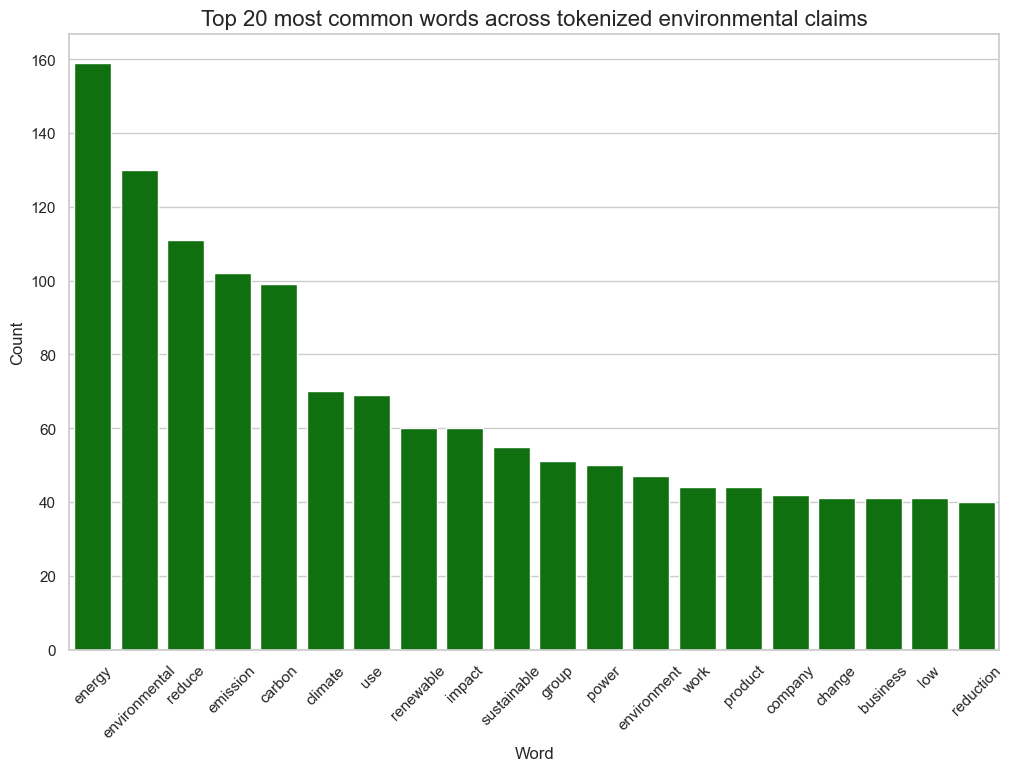

In [11]:
# Combine all claims' text into a single string
all_text = ' '.join(df_train_bis['tokens'].tolist())

# Tokenize the text by splitting on whitespace
words = all_text.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Get n most frequent words
n = 20  # Specify the number of most frequent words I want to retrieve
most_frequent_words = word_counts.most_common(n)

# create a list of most frequent words
most_common = [{"Word": word, "Frequency": frequency} for word, frequency in most_frequent_words]
word_common = pd.DataFrame(most_common)
word_common.set_index("Word",inplace=True)
display(word_common)

#visualize the 10 most common words in a bar chart 
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.barplot(x=word_common.index[:20], y=word_common["Frequency"][:20], color="green")
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 20 most common words across tokenized environmental claims", fontsize = 16)
plt.xticks(rotation=45)
plt.show()

From the bar charts provided, we can now discern the presence of specific "buzzwords" commonly found in environmental claims. These words tend to align with environmentally friendly concepts, such as energy, reduction, and climate. Consequently, it is reasonable to expect that phrases labeled as 1 would consist of these words. As we proceed with the analysis, both in the predictive phase of the testing set and annual bank reports, it would not be unexpected to find that phrases predicted as "environmental claims" contain these particular words.

#### 2. Explore Company affiliation within sentences

We continue our data analyses with a closer look at entities which are given in the sentences. These include organizations, individuals, locations, dates, and numerical values. From this baseline, we will shed light on company references given by the sentence. This could either be a statement by a third party targeting a specific company, or the company was publishing this sentence directly.

In [12]:
#taking a closer look at the claims different entities
first_10_lines = df_train["text"].head(10)
text_10 = first_10_lines.to_list()
docs = [sp(text) for text in text_10]

for i, doc in enumerate(docs):
    text_10_num = (f"Claim {i+1}:")
    print(text_10_num) 
    displacy.render(doc,style="ent",jupyter=True)

Claim 1:


c:\Users\Charlotte Ahrens\anaconda3\lib\site-packages\spacy\displacy\__init__.py:215: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


Claim 2:


Claim 3:


Claim 4:


Claim 5:


Claim 6:


Claim 7:


Claim 8:


Claim 9:


Claim 10:


In [13]:
entities = []
companies = []

for text in df_train["text"]:
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Change accented characters like é -> e
    text = unidecode.unidecode(text)
    doc = sp(text)
    orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    ent = [ent.text for ent in doc.ents if ent.label_]
    # Remove duplicates and empty strings
    orgs = list(set([org.strip() for org in orgs if org.strip()]))
    ent = list(set([e.strip() for e in ent if e.strip()]))
    companies.append(orgs)
    entities.append(ent)

# Add companies and entities as new columns to the DataFrame
df_train["companies"] = companies
df_train["entities"] = entities

display(df_train)

,text,label,word_count,companies,entities
0,It will enable E.ON to acquire and leverage a ...,0,34,[EON],[EON]
1,And that's honestly most markets in the U.S. S...,0,37,[],"[US, 70]"
2,A key pillar of our strategy is to continue to...,0,39,[],[]
3,The goal to reduce relative GHG emissions by 2...,1,15,[GHG],"[2013, 20, GHG, 2020]"
4,"As you know, we drove about $75 million of cos...",0,17,[],"[fiscal year 18, about 75 million, last year]"
...,...,...,...,...,...
2395,The collaboration will enable Nestlé to delive...,1,26,[Nestle],[Nestle]
2396,Through the MOBILITY THAT ADAPTS TO MEET NEEDS...,0,35,"[Renault Tech, Renault]","[Renault Tech, European, 2009, Renault]"
2397,While we are making progress towards our near ...,0,25,[],[]
2398,"On 5 December 2019, the Federal Network Agency...",0,27,[the Federal Network Agency],"[the Federal Network Agency, 139 2020 to 2030,..."


Company: ['MW'], Count: 14
Company: ['LNG'], Count: 11
Company: ['Bank'], Count: 6
Company: ['EDF'], Count: 5
Company: ['UN'], Count: 4
Company: ['ESG'], Count: 4
Company: ['Airbus'], Count: 4
Company: ['RD'], Count: 3
Company: ['Climate'], Count: 3
Company: ['ROIC'], Count: 3
Company: ['Tokio Marine Group'], Count: 3
Company: ['BBVA'], Count: 3
Company: ['AXA'], Count: 3
Company: ['TCFD'], Count: 3
Company: ['NGL'], Count: 2
Company: ['Nordea'], Count: 2
Company: ['FENC'], Count: 2
Company: ['Energy'], Count: 2
Company: ['Companys'], Count: 2
Company: ['the Paris Agreement'], Count: 2
Company: ['NTPC'], Count: 2
Company: ['VOC'], Count: 2
Company: ['Hydro'], Count: 2
Company: ['KLP'], Count: 2
Company: ['Groups'], Count: 2
Company: ['VERBUND'], Count: 2
Company: ['NYSPSC'], Count: 2
Company: ['CH4'], Count: 2
Company: ['FPSO'], Count: 2
Company: ['Alliance'], Count: 2
Company: ['EV'], Count: 2
Company: ['MTN'], Count: 2
Company: ['the Task Force'], Count: 2
Company: ['EU'], Count: 2
C

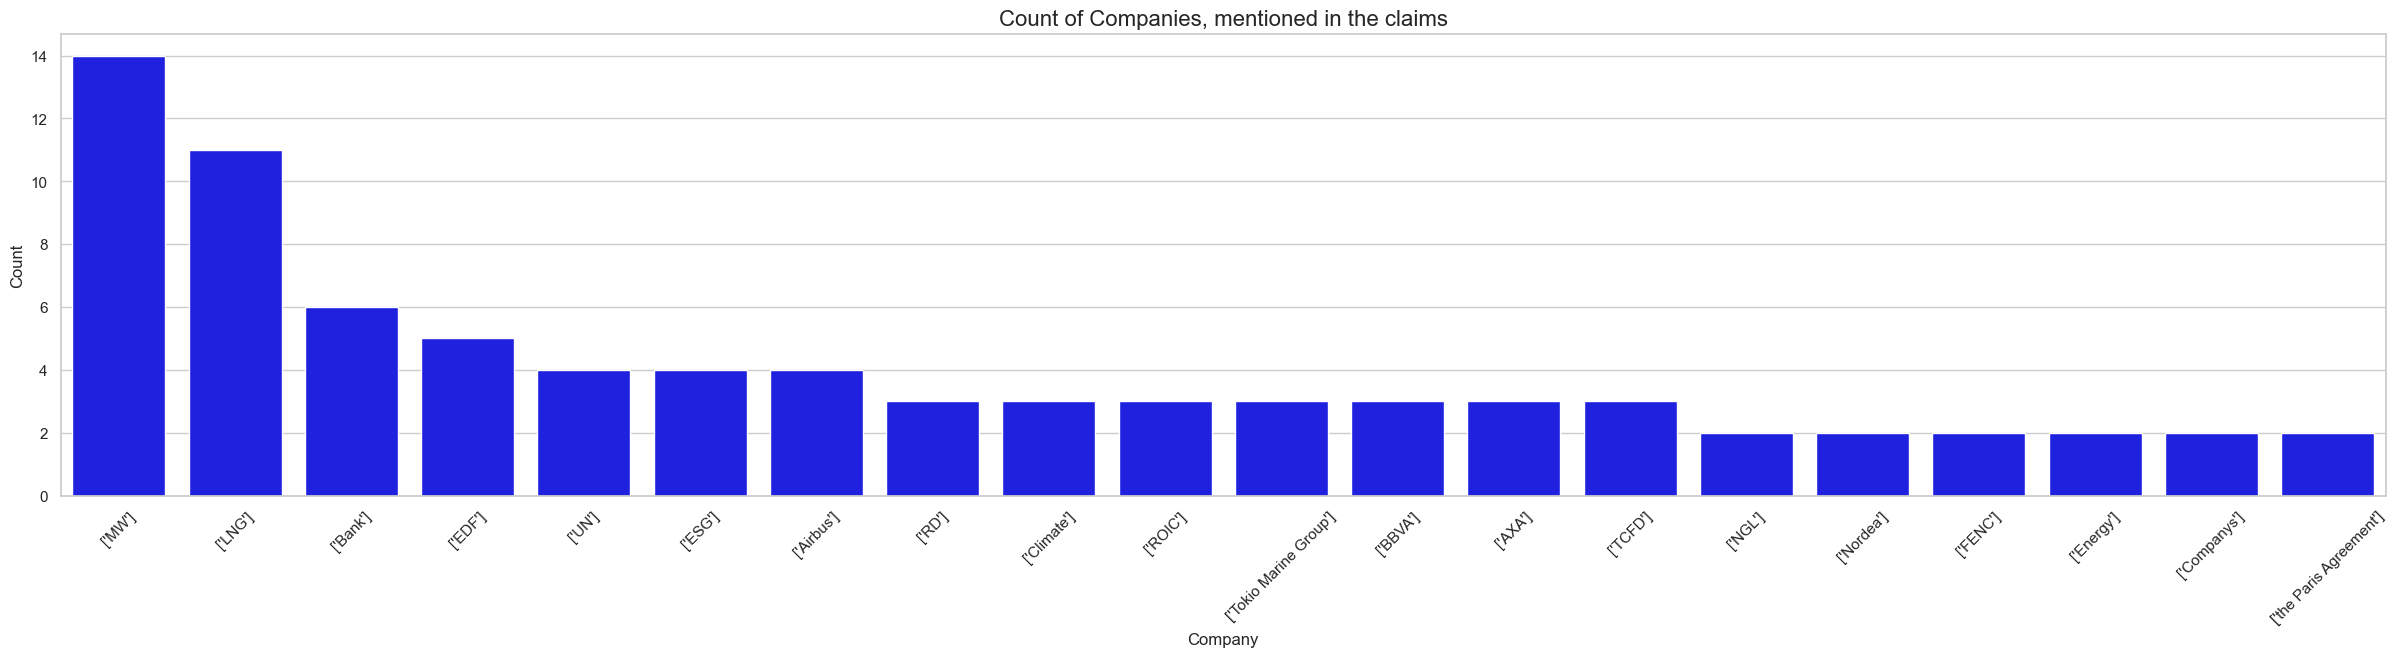

In [23]:
#looking for multiples in terms of the company name, including all type of claims
company_counts = df_train["companies"].value_counts()
multiple_times = company_counts[(company_counts > 1) & (company_counts < 16)] #restrict to < 16 to exclude nan's and other entities that were titled as companies, but are other acronyms like GHG
for company, count in multiple_times.items():
    print(f"Company: {company}, Count: {count}")
    
#calculate the total count of company names given
total_count = multiple_times.values.sum()
print(f" The total count of companies that we have the company name for:",total_count)

#displaying the count of companies visually 
sns.set(style="whitegrid")
plt.figure(figsize=(30,6))

sns.barplot(x=multiple_times.index.map(str)[:20], y=multiple_times.values[:20], color="blue")
plt.xlabel("Company")
plt.ylabel("Count")
plt.title("Count of Companies, mentioned in the claims",fontsize =16)
plt.xticks(rotation=45)
plt.show()

The plot graph indicates, that not all companies where correctly found by the entity function, as it includes for instance Bank, ESG, and Climate. However, it gives a rough understanding that several sentences within our dataset are referring to the same companies.Some exceptions where no clear conclusion can be drawn are the two highest count acronyms. MW, an acronym referring to either the MW company or MegaWatts, as well as the Liquefied Natural Gas Industry (LNG) or the LNG american based energy company, have been included in several sentences, but since we are missing the context, this reference must be considered with care. 
Further we check if an organization, when they have several sentences in the data set, has claims labelled as environmental claim while another claim of this company has been labelled as an environmental claim. First we take "Airbus" as an example.

In [15]:
#exploring row that talk about a specific company for example Airbus
company_name = "Airbus"
company_Airbus = df_train[df_train["companies"].apply(lambda x: company_name in x)]
display(company_Airbus)

#df_train[df_train["companies"].str.contains("Airbus")]

,text,label,word_count,companies,entities
162,As part of this program we are expecting to in...,0,18,[Airbus],"[A320, Airbus]"
904,"In conjunction with the new order, we also res...",0,31,[Airbus],"[Airbus, 25]"
1785,This enables Airbus to measure its environment...,0,22,[Airbus],[Airbus]
1886,In connection with our plans to launch flights...,0,34,[Airbus],"[April 2019, A321 Long Range, Airbus, London, ..."


Airbus shows only non environmental claims, therefore let's take a look at the top players in terms of count of environmental claims.

,text,label,word_count,companies,entities
3,The goal to reduce relative GHG emissions by 2...,1,15,[GHG],"[2013, 20, GHG, 2020]"
5,1.2 Significant Changes to Assets In February ...,1,38,"[AGL, the Powering Australian Renewables Fund ...","[the Powering Australian Renewables Fund PARF,..."
7,This not only provides a clean energy solution...,1,23,[],[]
9,The Group has therefore built its sustainabili...,1,35,[Group],"[four, Group]"
14,Waste As part of our ambitions to move toward ...,1,23,[],[]


Company: [], Count: 305
Company: ['Group'], Count: 11
Company: ['Company'], Count: 9
Company: ['GHG'], Count: 6
Company: ['Bank'], Count: 5
Company: ['ESG'], Count: 3
Company: ['EDF'], Count: 3
Company: ['UN'], Count: 3
Company: ['VERBUND'], Count: 2
Company: ['Tokio Marine Group'], Count: 2
Company: ['Alliance'], Count: 2


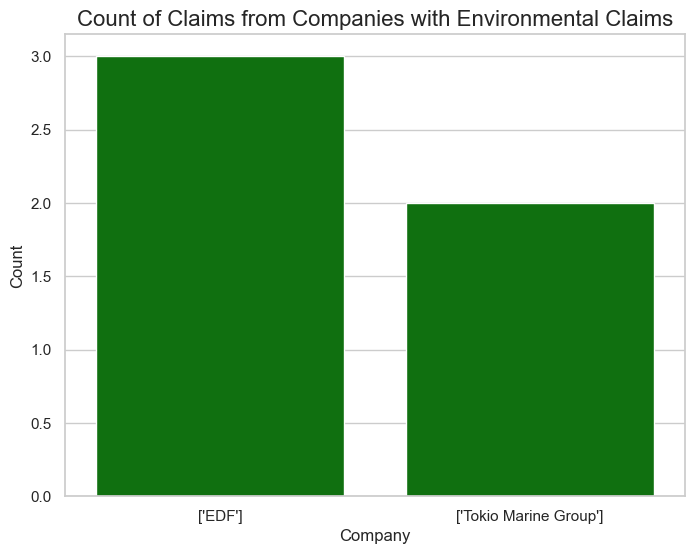

In [16]:
#the above shows that all Airbus claims where labelled as non-environmental claims. To get a better idea of companies that used such statements we focus on environmental claims only.
df_train_env= df_train[df_train["label"] ==1]
display(df_train_env.head())

#looking for multiples in terms of the company name
company_counts = df_train_env["companies"].value_counts()
multiple_times_env = company_counts[company_counts >1]

#displaying companies that have green claims
for company, count in multiple_times_env.items():
    print(f"Company: {company}, Count: {count}")
# -> we see that most filtered "companies" are not actual companies .> filter accordingly

#visually presenting the count of companies that are labelled with environmental claims  
# Filter the specific companies
selected_companies = [["EDF"], ["Tokio Marine Group"]]
filtered_counts = multiple_times_env[multiple_times_env.index.isin(selected_companies)]

# Plot the counts of selected companies
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(x=filtered_counts.index.map(str), y= filtered_counts.values,color="green")
plt.xlabel("Company")
plt.ylabel("Count")
plt.title("Count of Claims from Companies with Environmental Claims", fontsize =16)
plt.xticks(rotation=0)
plt.show()

In [17]:
#check statements with multiple company counts including green and non green claims // eg: EDF = British integrated energy company, French state-owned by EDF (Électricité de France)
pd.set_option('display.max_colwidth', None)# setting wide column to display whole text
company_name = "EDF"
company_EDF = df_train[df_train["companies"].apply(lambda x: company_name in x)]
display(company_EDF[["text","label"]])

pd.reset_option('display.max_colwidth') # resetting the column size to normal

,text,label
242,"The hydropower facilities have positive effects on both economic development and the environment, and EDF applies a proactive management policy in relation to water resources, in liaison with various water stakeholders.",1
632,"Within the EpE (3), EDF also contributed to a global study on the carbon neutrality of France in 2050.",1
738,All EDF group business lines are working to cut the carbon impact of the refrigerating fluids they use.,1
753,"In March 2020, EDF committed with ARVAL to facilitating access to electric mobility for both business and residential customers, based on IZI by EDF.",0
949,"In January 2021, the EDF group ranked first in the list of the most credible companies in terms of communication, in the utilities/energy category (1).",0
1012,"As part of the ""Coup de Pouce Chauffage"" (3) scheme, EDF launched in January 2019 its ""Mon chauffage durable"" offer, to finance replacing ageing heating systems by more efficient ones.",0
1534,"Consequently, the Group has an “energy markets” risk policy for all energy commodities, applicable to EDF and entities over which it has operational control.",0
1556,"In terms of new business lines, EDF is aiming to have a portfolio of 1 million off-grid kits by 2030 and is pursuing the development of new markets such as microgrids, smart grids, storage, hydrogen, mobility, smart cities, etc.,",0


EDF and Tokio Marine Group are companies that appear within both top lists, and therefore have examples of non-/environmental claims. Therefore, there are several statements from some companies, while some are labelled as environmental claims, while others are not. 

#### 3. Explore time period within sentences

Lastly, we will explore the years that are stated within the claims. Again, this does not necessarily mean, a claim was made in that year, but rather it refers to a previous or upcoming event or goal.

In [18]:
#check statements based on year-> did the count increase? This is difficult to show since the 
year = []
for text in df_train_env["text"]:
    #remove punctuation
    text = text.translate(str.maketrans("","", string.punctuation))
    #change accented characters like é -> e
    text = unidecode.unidecode(text)
    doc = sp(text)
    years = [ent.text for ent in doc.ents if ent.label_ == "DATE"]
    #remove duplicates and empty strings
    years = list(set([year.strip() for year in years if year.strip()]))
    year.append(years)
    
df_train_env.copy()
df_train_env["year"] = year
display(df_train_env)
year_counts = df_train_env["year"].value_counts()
print(year_counts.index.sort_values(ascending=True))

C:\Users\Charlotte Ahrens\AppData\Local\Temp\ipykernel_5960\1419733408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_env["year"] = year


,text,label,word_count,companies,entities,year
3,The goal to reduce relative GHG emissions by 2...,1,15,[GHG],"[2013, 20, GHG, 2020]","[2013, 2020]"
5,1.2 Significant Changes to Assets In February ...,1,38,"[AGL, the Powering Australian Renewables Fund ...","[the Powering Australian Renewables Fund PARF,...",[February 2016]
7,This not only provides a clean energy solution...,1,23,[],[],[]
9,The Group has therefore built its sustainabili...,1,35,[Group],"[four, Group]",[]
14,Waste As part of our ambitions to move toward ...,1,23,[],[],[]
...,...,...,...,...,...,...
2383,I would also just say that things -- we are on...,1,17,[],[],[]
2384,"In 2019, we purchased 128,873 tonnes of United...",1,27,"[United Nations, GHG emissions12]","[128873, 3, 1 2, GHG emissions12, fiscal 2019,...","[128873, fiscal 2019, 2019]"
2391,We have committed to reach net-zero greenhouse...,1,16,[],[2050],[2050]
2393,"Furthermore, we will contribute to the prevent...",1,23,[IoT],[IoT],[]


Index([                                         [],
                         ['06891', '2019', '2018'],
                                ['1 January 2016'],
                                       ['10 year'],
                              ['11 years', '1978'],
                 ['128873', 'fiscal 2019', '2019'],
                                         ['16128'],
                                 ['20 yearonyear'],
                                          ['2004'],
                              ['2005', 'annually'],
                                          ['2007'],
                       ['2007-12', '2009', '2007'],
                                          ['2009'],
                                          ['2010'],
                                          ['2013'],
                                  ['2013', '2020'],
                                        ['201314'],
                                          ['2014'],
                                      ['20142020'],
            

The table above gives shows dates for each sentence, where any kind of date is indicated. In order to unify the various date formats, we focus only on the year given within the sentence. 

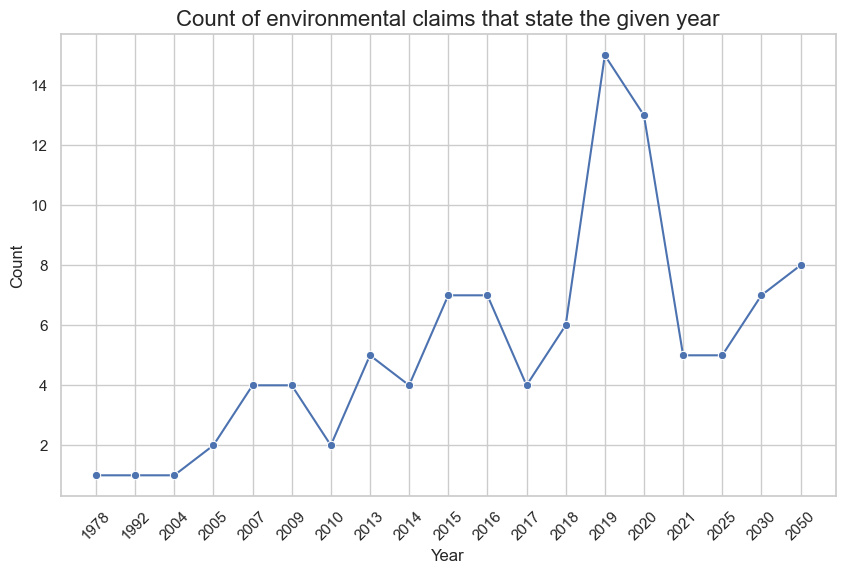

In [19]:
year_indexes = df_train_env["year"].dropna().index

# Extracting years starting from 1900and removing months and days
years = [re.findall(r"\b(?:19|20|21)\d{2}\b", str(year)) for year in df_train_env.loc[year_indexes, "year"]]
filtered_years = [year[0] if year else "" for year in years]  # Keep the first year only as otherwise we cannot interpret the year

# Assigning the filtered years back to the DataFrame
df_train_env.loc[year_indexes, "year"] = filtered_years
filtered_years

# Counting the occurrences of each year
year_counts = pd.Series(filtered_years).value_counts().sort_index()

# Filtering years starting from 1900
filtered_year_counts = year_counts[year_counts.index >= "1900"]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(x=filtered_year_counts.index, y=filtered_year_counts.values, marker='o')
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Count of environmental claims that state the given year", fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


**The key takeaways of the Exploratory Data Analysis (EDA) are the following:**
- The training and test set is quite unbalanced in terms of labelled=0 and labelled=1 data. Therefore, working on the dataset will also be key on achieving the best prediction metrics.
- The most common words within the training set are as expected articles like ("the", "a"), prepositions ("to","of","in"), and various forms of the verbs ("to be"," to have"). It will be important to give those words less importance for example through the TF-IDF model. This is why we will use a tokenizer. The most important word that gives a hint about the context is "energy", on rank 18th with a count of 290 words across all claims. 
- By focusing on Environmental claims and utilizing a tokenizer that eliminates insignificant words, as discussed earlier, we successfully identified recurring buzz words in these types of sentences. The top three are "energy" "environmental" and "reduce." Based on this finding, phrases within our testing set that incorporate these words are more inclined to be classified as environmental claims in our predictive model. 

- When selecting the claims that are coming from a specific company, we have four main observations:
    1. Within the 2400 claims the sample shows multiple claims from one company.
    2. The company is not determining if a claim is labels as environmental or not since we find both labels within claims of the same company.
    3. We only have the company's name for a minority of the claims. 
    4. Considering only environmental claims, we have multiple claims and the company name information only for EDF, an Energy firm in the UK as  well as for Tokio Marine Group, a multinational insurance holding company, based in Tokyo, Japan.    
    
- When selecting the claims that are specifying a given year, the main observations are: 
    1. 2015, 2019 and 2020 show a relative peak in environmental claims. 2015 is likely to be due to teh year of the Paris Agreement, meaning several claims where either made in that time or refer to that year within their statement. In terms of the rise in the year 2019 and 2020, it is likely to be mentioned more often due to the time period when the dataset was fed with claims.
    2. Years that lay in the future are likely to come from claims that state information about future targets.
    3. Due to the high amount of missing years for environmental claims, the line graph gives just an idea of behavior, but no concrete information.